# **Cluster Profiling and Behavioral Segmentation Analysis.**
Este notebook tiene como objetivo analizar y caracterizar los grupos de clientes generados en la fase previa de modelado de clustering, en la cual se aplicaron técnicas de reducción de dimensionalidad (PCA, t-SNE) y agrupamiento no supervisado.

La interpretación de los clusters es clave para convertir los resultados algorítmicos en conocimiento accionable. A través del análisis descriptivo de cada grupo, se busca:

- Identificar patrones comunes en variables demográficas, económicas y digitales
- Detectar perfiles con riesgo de abandono o alto valor
- Validar la coherencia del modelo a nivel de negocio
- Preparar la base para recomendaciones estratégicas y personalización de campañas

La caracterización se realizará mediante estadísticas descriptivas, visualizaciones comparativas (boxplots, barras, mapas si aplica) y segmentación simbólica.

Este paso es esencial para traducir el trabajo técnico en insights útiles para stakeholders y equipos de marketing o fidelización.

## **Importación de librerías y configuración general.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con bases de datos, manipulación de datos y archivos. También se desactivan ciertos mensajes de advertencia que podrían ensuciar la salida.

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import numpy as np
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## **Importación e información del Dataframe.**
En esta sección se importa el conjunto de datos ya codificado y limpio, generado en el notebook anterior. Se verifican su forma y características básicas para asegurar consistencia antes de aplicar modelos.

In [227]:
df = pd.read_csv('../data/processed/IA_Client_Segment_sample_v2.csv', index_col=0)
df.head()

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5,Cluster_PCA,Cluster_tSNE,t-SNE1,t-SNE2,PC1,PC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,2,0,3,1,93442,1385,80,1,195,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,1,-80.811960,-15.905197,-1.767486,-0.863035
CLI100,1,1,64,1,2,1,2,1,99774,1052,50,1,360,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,2,-14.199878,48.544800,-1.915343,-0.010575
CLI1000,1,1,65,1,2,1,3,1,36756,1717,30,0,407,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,4,1,-37.562958,19.352694,-0.752088,0.886234
CLI10000,1,0,33,0,1,0,4,2,24616,1606,30,0,544,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,55.123444,-33.282143,2.047761,0.178861
CLI10001,1,1,52,0,2,1,2,1,29834,1346,30,1,170,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,2,-13.119754,30.240702,-0.504011,0.529194


In [228]:
df.columns

Index(['Genero', 'Casado', 'Edad', 'Graduado', 'Experiencia_laboral',
       'Gastoscore', 'Family_Size', 'Generacion', 'Ingresos_anuales_brutos',
       'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Abandono',
       'Dias_cliente', 'Profesion_Construcción', 'Profesion_Empresarial',
       'Profesion_Funcionario', 'Profesion_Otros', 'Profesion_Servicios',
       'Profesion_Técnico', 'Zona_Centro', 'Zona_Levante', 'Zona_Noreste',
       'Zona_Noroeste', 'Zona_Norte', 'Zona_Periferia', 'Zona_Sur',
       'Campaña__0', 'Campaña__1', 'Campaña__3', 'Campaña__4', 'Campaña__5',
       'Cluster_PCA', 'Cluster_tSNE', 't-SNE1', 't-SNE2', 'PC1', 'PC2'],
      dtype='object')

## **Evaluación de la calidad de la segmentación.**
Antes de avanzar con la interpretación de los clusters, es esencial validar que la segmentación obtenida es **coherente, robusta y estructuralmente sólida**.

En esta sección se realizará una evaluación técnica de la calidad de los grupos obtenidos, utilizando tres enfoques complementarios:

1. **Matriz de coincidencia entre los clusters generados con PCA y su proyección en t-SNE**: Esto permite verificar si la segmentación basada en reducción lineal (PCA) se mantiene coherente en un espacio no lineal (t-SNE), lo cual indica estabilidad estructural.

2. **Visualización comparativa de clusters**: Se proyectarán los resultados en los planos PCA y t-SNE para evaluar la separación visual de los grupos y la consistencia espacial.

3. **Cálculo del Índice de Segmentación**: Se calculará una métrica interna que compara la **varianza intra-cluster frente a la varianza total**, lo cual permite cuantificar el nivel de diferenciación entre los grupos.

Este análisis conjunto permite justificar la validez técnica de los clusters obtenidos y aporta confianza para continuar con su interpretación estratégica.

### **Matriz de coincidencia entre PCA y t-SNE.**
Para validar la solidez estructural de la segmentación obtenida mediante PCA, se compara su asignación de clusters con la agrupación visual proyectada en el espacio t-SNE.

Esta matriz permite observar hasta qué punto **los grupos formados en un espacio lineal (PCA)** se mantienen **coherentes cuando los datos se representan de forma no lineal** mediante t-SNE.

Un alto grado de coincidencia entre ambos métodos indica que los clusters no son artificios del modelo, sino que reflejan **estructuras reales presentes en el comportamiento de los clientes**, fortaleciendo la confianza en la segmentación obtenida.

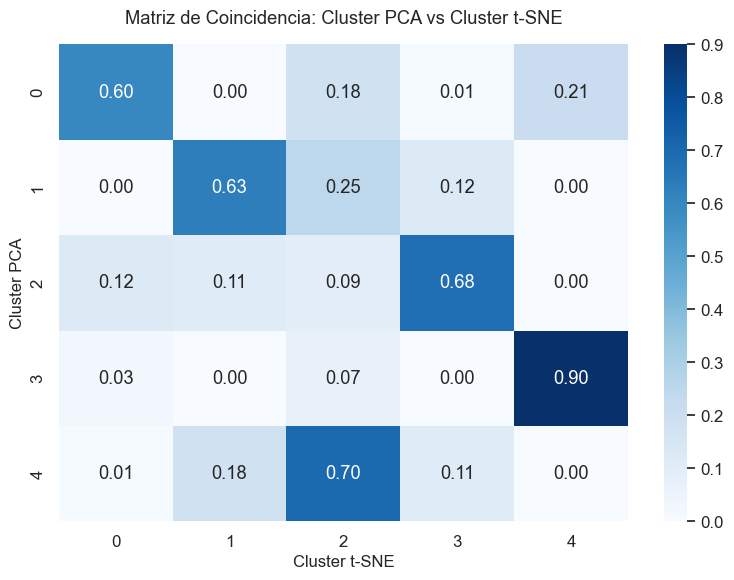

In [229]:
# Matriz de coincidencia.
coincidence_matrix = pd.crosstab(df['Cluster_PCA'], df['Cluster_tSNE'], normalize='index').round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(coincidence_matrix, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Matriz de Coincidencia: Cluster PCA vs Cluster t-SNE", pad=15)
plt.xlabel("Cluster t-SNE", fontsize=12)
plt.ylabel("Cluster PCA", fontsize=12)
plt.tight_layout()
plt.show()

In [230]:
# Remapear los clusters t-SNE a los clusters PCA para una mejor interpretación.
remap_tsne = {
    0: 0,  # t-SNE 0 ≈ PCA 0
    1: 1,  # t-SNE 1 ≈ PCA 1
    2: 4,  # t-SNE 2 ≈ PCA 4
    3: 2,  # t-SNE 3 ≈ PCA 2
    4: 3   # t-SNE 4 ≈ PCA 3
}

# Crear una columna remapeada temporal para visualización
df['Cluster_tSNE'] = df['Cluster_tSNE'].map(remap_tsne)

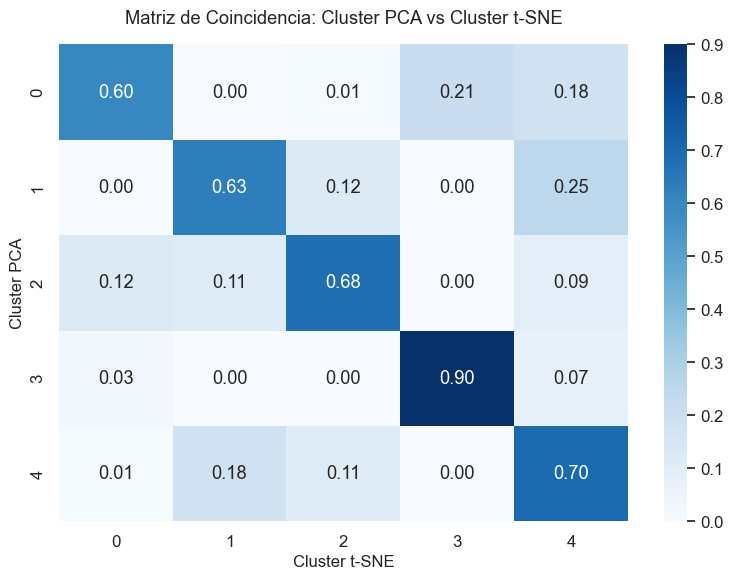

In [231]:
# Matriz de coincidencia.
coincidence_matrix = pd.crosstab(df['Cluster_PCA'], df['Cluster_tSNE'], normalize='index').round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(coincidence_matrix, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Matriz de Coincidencia: Cluster PCA vs Cluster t-SNE", pad=15)
plt.xlabel("Cluster t-SNE", fontsize=12)
plt.ylabel("Cluster PCA", fontsize=12)
plt.tight_layout()
plt.show()

El análisis de coincidencia entre los clusters generados mediante **PCA** y su proyección en el espacio **t-SNE** revela una alta consistencia estructural entre ambos enfoques. En particular:

- Los clusters **1, 2, 3 y 4** presentan una correspondencia clara con grupos específicos en t-SNE, con proporciones dominantes superiores al **63%**, destacando especialmente el **Cluster 3**, con una coincidencia del **90%**.
- El **Cluster 0**, si bien muestra algo más de dispersión, mantiene una asignación dominante hacia un único grupo (60%), lo que indica una estructura razonablemente definida.

Este resultado sugiere que los clusters formados a partir del modelo PCA **reflejan patrones reales presentes en los datos**, incluso al ser representados en un espacio de mayor complejidad no lineal como t-SNE.

Desde el punto de vista técnico y estratégico, esto **valida el uso del modelo PCA como base principal para la segmentación**, ya que ha demostrado generar grupos coherentes, estables y trasladables entre diferentes representaciones del espacio de datos.

### **Visualización comparativa de clusters en PCA y t-SNE.**
Tras validar cuantitativamente la coherencia entre los clusters obtenidos con PCA y su representación en t-SNE, en esta sección se busca **evaluar visualmente la calidad y separación de los grupos** en ambos espacios.

La representación gráfica permite observar:
- La **distribución espacial** de los clientes según los primeros dos componentes principales del PCA.
- Cómo se **agrupan los clientes en el espacio no lineal** de t-SNE.
- La **compacidad, separación y forma** de los clusters desde distintas perspectivas.

Esta comparación no solo refuerza la solidez técnica del modelo PCA, sino que también ayuda a **identificar posibles solapamientos o subgrupos** que podrían tener implicaciones estratégicas.

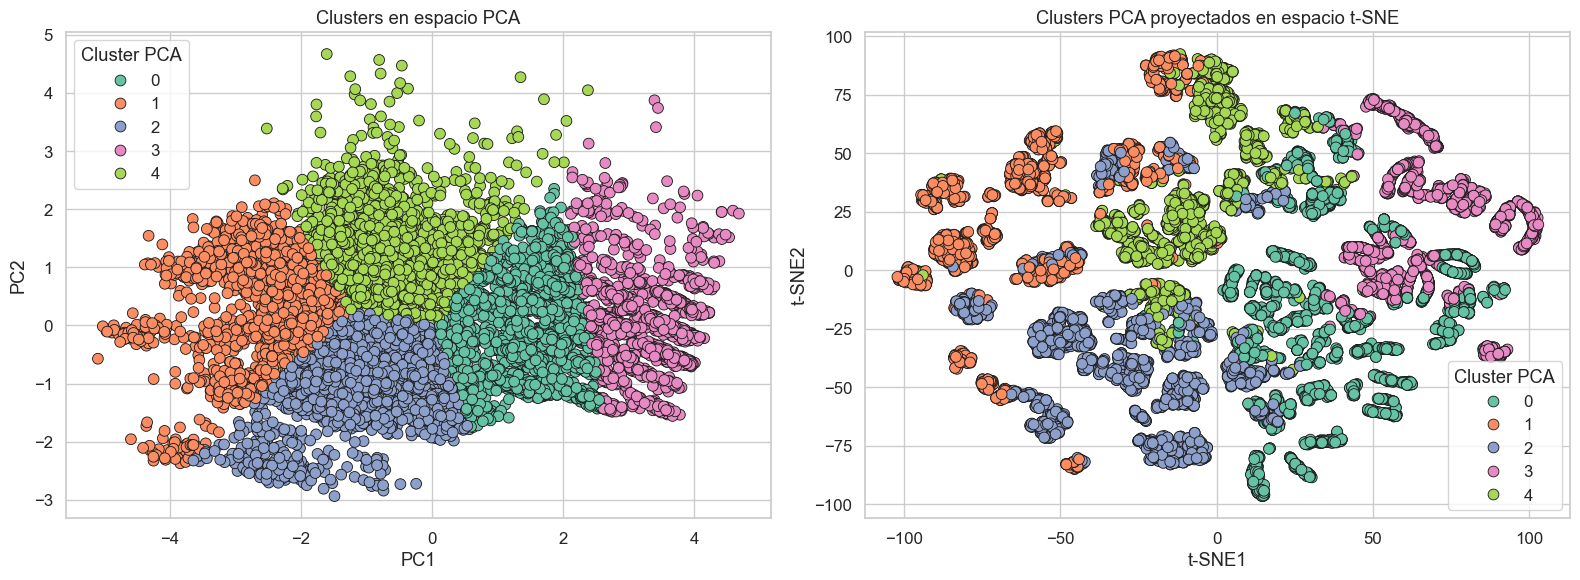

In [232]:
# Gráfica de dispersión de los clusters PCA y t-SNE.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA.
sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="Cluster_PCA", palette="Set2",
    ax=axes[0], s=60, edgecolor='k'
)
axes[0].set_title("Clusters en espacio PCA")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title='Cluster PCA', loc='best')

# t-SNE.
sns.scatterplot(
    data=df, x="t-SNE1", y="t-SNE2", hue="Cluster_PCA", palette="Set2",
    ax=axes[1], s=60, edgecolor='k'
)
axes[1].set_title("Clusters PCA proyectados en espacio t-SNE")
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")
axes[1].legend(title='Cluster PCA', loc='best')

plt.tight_layout()
plt.show()

**Interpretación.**
1. **Estructuras claras**: El gráfico de t-SNE muestra grupos **bien definidos**, sin mezcla caótica. Eso indica que los datos que recibió t-SNE ya estaban **bien representados**, lo cual habla bien del PCA.

2. **Grupos con formas limpias**: Aunque t-SNE tiende a separar todo, la forma en que se agrupan los puntos no parece artificial. Eso sugiere que el **PCA no aplastó ni distorsionó la estructura interna**.

3. **Colores (clusters) siguen siendo consistentes**: Los mismos clusters definidos en PCA se proyectan de forma **coherente** en t-SNE. Si el PCA hubiera perdido demasiada información, t-SNE no podría haber recuperado estas formas.

En conjunto, esta proyección **refuerza la validez del modelo de PCA**, demostrando que los grupos detectados reflejan patrones reales del comportamiento del cliente, y no son un resultado artificial de la técnica.

In [233]:
df.drop(columns=['Cluster_tSNE', 't-SNE1', 't-SNE2', 'PC1', 'PC2'], inplace=True) # Eliminación de columnas innecesarias.

## **Perfilado de variables por cluster: Índice por variable.**
Para comprender en profundidad las características que definen cada grupo, es fundamental analizar cómo se comportan las variables originales dentro de cada cluster. Con este fin, se ha calculado un **índice de caracterización por variable**, el cual permite identificar las dimensiones más representativas en cada segmento.

Este índice se define como el **cociente entre el valor medio de una variable dentro de un cluster y su valor medio global** en todo el dataset:

$$
\text{Índice}_{\text{variable}} = \frac{\text{Media de la variable en el cluster}}{\text{Media global de la variable}}
$$


- Si el índice es **mayor que 1**, la variable está **sobrerrepresentada** en ese cluster, y por tanto puede actuar como un **rasgo diferenciador positivo**.
- Si el índice es **menor que 1**, la variable está **infrarrepresentada**, lo que puede indicar una **ausencia significativa o una tendencia inversa**.
- Si el índice es cercano a **1**, el comportamiento del cluster respecto a esa variable es **similar al promedio general**.

Este análisis permite identificar rápidamente **qué características distinguen a cada cluster**, y se convierte en una herramienta clave para el **naming estratégico de segmentos**, la **definición de perfiles de cliente** y el diseño de **acciones personalizadas en campañas de marketing** o decisiones de negocio.

In [234]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Cluster_PCA'], errors='ignore').columns

In [235]:
# Selección de variables numéricas para el análisis.
variables_numericas = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Cluster_PCA'], errors='ignore').columns

# Cálculo de medias.
media_global = df[variables_numericas].mean()
media_por_cluster = df.groupby('Cluster_PCA')[variables_numericas].mean()

# Índice por variable = media en cluster / media global.
indice_por_variable = media_por_cluster.div(media_global).round(2)

In [236]:
indice_por_variable

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5
Cluster_PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.93,0.56,0.73,0.96,0.60,0.35,0.96,1.34,0.53,1.01,0.72,0.99,1.00,1.78,0.71,1.41,1.21,0.63,1.40,1.05,1.01,1.01,0.97,1.02,1.01,0.97,1.00,0.80,1.05,1.11,0.95
1,1.04,1.69,1.49,1.24,1.44,2.44,0.88,0.42,1.54,0.79,1.50,1.05,1.01,0.43,1.22,0.03,0.60,1.71,0.45,0.99,1.04,0.93,1.07,0.90,1.03,0.99,0.99,1.01,1.00,0.98,1.05
2,0.91,1.02,1.12,1.28,1.39,0.25,0.58,0.77,1.42,0.92,1.27,0.98,1.00,1.00,0.56,0.21,1.27,1.34,1.01,1.01,0.98,1.02,0.97,1.09,0.96,0.99,0.99,1.91,0.83,0.77,1.05
3,1.07,0.09,0.52,0.29,0.02,0.06,1.49,1.78,0.38,1.55,0.70,0.96,0.98,0.59,0.76,3.92,0.48,0.17,0.85,0.97,1.03,1.00,1.04,0.92,0.97,1.01,1.03,0.01,1.19,1.18,0.91
4,1.14,1.65,1.10,0.96,1.36,2.31,1.42,0.82,1.00,0.87,0.72,1.02,1.00,0.78,2.07,0.18,1.15,0.96,1.11,0.94,0.94,1.04,0.99,1.01,1.03,1.05,1.00,0.76,1.01,1.06,1.02


Una vez calculado el índice por característica, es posible realizar una lectura estratégica y descriptiva de los perfiles que emergen en cada cluster. Este análisis permite identificar qué dimensiones definen a cada grupo, ya sea por su sobre-representación (índice > 1) o por su sub-representación (índice < 1).

In [237]:
# Cluster 0: Evaluación de variables.
pd.DataFrame({
    'Índice': indice_por_variable.loc[0],
    'Tipo': ['⇩ Menor al promedio' if val < 1 else '⇧ Mayor al promedio' for val in indice_por_variable.loc[0]]
})

,Índice,Tipo
Genero,0.93,⇩ Menor al promedio
Casado,0.56,⇩ Menor al promedio
Edad,0.73,⇩ Menor al promedio
Graduado,0.96,⇩ Menor al promedio
Experiencia_laboral,0.60,⇩ Menor al promedio
Gastoscore,0.35,⇩ Menor al promedio
Family_Size,0.96,⇩ Menor al promedio
Generacion,1.34,⇧ Mayor al promedio
Ingresos_anuales_brutos,0.53,⇩ Menor al promedio
Digital_encuesta,1.01,⇧ Mayor al promedio


**Diagnóstico Cluster 0.** Este segmento representa un grupo de **clientes jóvenes, con bajo poder adquisitivo, escasa experiencia laboral y menor participación histórica**, pero que **muestran señales de activación reciente**. A continuación, se resumen sus principales rasgos y cómo deben ser tratados estratégicamente:

| Categoría                  | Tendencia general         |
|---------------------------|---------------------------|
| Edad y etapa vital        | ⇩ Jóvenes                 |
| Ingresos y gasto          | ⇩ Bajo poder adquisitivo  |
| Educación y estado civil  | ⇩ Menor formación y vinculación familiar |
| Experiencia laboral       | ⇩ Trayectoria inicial     |
| Profesión                 | ⇧ Técnicos, funcionarios y construcción |
| Digitalización            | ⇧ Ligeramente superior    |
| Respuesta a campañas      | ⇧ Mejores resultados en campañas recientes |

In [238]:
# Cluster 1: Evaluación de variables.
pd.DataFrame({
    'Índice': indice_por_variable.loc[1],
    'Tipo': ['⇩ Menor al promedio' if val < 1 else '⇧ Mayor al promedio' for val in indice_por_variable.loc[1]]
})

,Índice,Tipo
Genero,1.04,⇧ Mayor al promedio
Casado,1.69,⇧ Mayor al promedio
Edad,1.49,⇧ Mayor al promedio
Graduado,1.24,⇧ Mayor al promedio
Experiencia_laboral,1.44,⇧ Mayor al promedio
Gastoscore,2.44,⇧ Mayor al promedio
Family_Size,0.88,⇩ Menor al promedio
Generacion,0.42,⇩ Menor al promedio
Ingresos_anuales_brutos,1.54,⇧ Mayor al promedio
Digital_encuesta,0.79,⇩ Menor al promedio


**Diagnóstico Cluster 1.** Este grupo representa un **perfil mayor y económicamente consolidado**, formado por clientes con **alta experiencia laboral, elevados ingresos y fuerte nivel de gasto**. Además, presenta una **alta proporción de personas casadas y graduadas**, lo que sugiere estabilidad social y profesional.

Aunque su tamaño familiar es más reducido, esto probablemente se deba a su **etapa vital avanzada** (por ejemplo, parejas sin hijos a cargo o personas con hijos ya independizados). Su menor nivel de digitalización refuerza esta hipótesis generacional.

Es un segmento ideal para **estrategias de fidelización, servicios premium o productos financieros avanzados**, donde la rentabilidad por cliente es clave.


| Categoría                  | Tendencia general                     |
|---------------------------|----------------------------------------|
| Edad y etapa vital        | ⇧ Mayores con amplia trayectoria       |
| Estado civil              | ⇧ Alta proporción de casados           |
| Ingresos y gasto          | ⇧ Poder adquisitivo elevado            |
| Educación                 | ⇧ Mayor proporción de graduados        |
| Profesión                 | ⇧ Servicios y perfil ejecutivo         |
| Tamaño familiar           | ⇩ Hogares pequeños (etapa post-familiar) |
| Digitalización            | ⇩ Menor interacción digital            |
| Generación                | ⇩ Predominio de generaciones mayores   |
| Respuesta comercial       | ⇧ Participan más en campañas activas   |

In [239]:
# Cluster 2: Evaluación de variables.
pd.DataFrame({
    'Índice': indice_por_variable.loc[2],
    'Tipo': ['⇩ Menor al promedio' if val < 1 else '⇧ Mayor al promedio' for val in indice_por_variable.loc[2]]
})

,Índice,Tipo
Genero,0.91,⇩ Menor al promedio
Casado,1.02,⇧ Mayor al promedio
Edad,1.12,⇧ Mayor al promedio
Graduado,1.28,⇧ Mayor al promedio
Experiencia_laboral,1.39,⇧ Mayor al promedio
Gastoscore,0.25,⇩ Menor al promedio
Family_Size,0.58,⇩ Menor al promedio
Generacion,0.77,⇩ Menor al promedio
Ingresos_anuales_brutos,1.42,⇧ Mayor al promedio
Digital_encuesta,0.92,⇩ Menor al promedio


**Diagnóstico Cluster 2.** El Cluster 2 representa un grupo de **clientes económicamente acomodados**, con **altos ingresos y un gasto mensual significativamente elevado**. Aunque no son especialmente jóvenes, su edad está **ligeramente por encima de la media**, y su participación en campañas específicas, como la Campaña 1, es **notablemente alta**, lo que refleja **interés en acciones comerciales puntuales**.

Por otro lado, destacan por tener un **tamaño familiar pequeño** y una **menor respuesta en otras campañas recientes**, lo que podría indicar un comportamiento más selectivo o exigente frente a la comunicación de marca.

Este segmento es adecuado para estrategias de **upselling, fidelización personalizada y productos de valor medio-alto**, pero requiere campañas bien enfocadas.

| Categoría                  | Tendencia general                      |
|---------------------------|-----------------------------------------|
| Ingresos y gasto          | ⇧ Elevado poder adquisitivo             |
| Edad                      | ⇧ Ligeramente mayores                   |
| Respuesta comercial       | ⇧ Alta participación en Campaña 1       |
| Tamaño familiar           | ⇩ Hogares pequeños                      |
| Otras campañas recientes  | ⇩ Menor participación (selectividad)    |

**Diferencia clave con Cluster 1.** A primera vista se puden ver similares, pero hay diferencias notorias:
- Cluster 1 representa un perfil más tradicional: adultos mayores, casados, graduados, de profesión estable, con alta capacidad de gasto y una base relacional sólida.
- Cluster 2 es más económicamente enfocado: clientes con poder adquisitivo, que gastan mucho, pero con estructura familiar más reducida y un comportamiento más selectivo ante campañas.

In [240]:
# Cluster 3: Evaluación de variables.
pd.DataFrame({
    'Índice': indice_por_variable.loc[3],
    'Tipo': ['⇩ Menor al promedio' if val < 1 else '⇧ Mayor al promedio' for val in indice_por_variable.loc[3]]
})

,Índice,Tipo
Genero,1.07,⇧ Mayor al promedio
Casado,0.09,⇩ Menor al promedio
Edad,0.52,⇩ Menor al promedio
Graduado,0.29,⇩ Menor al promedio
Experiencia_laboral,0.02,⇩ Menor al promedio
Gastoscore,0.06,⇩ Menor al promedio
Family_Size,1.49,⇧ Mayor al promedio
Generacion,1.78,⇧ Mayor al promedio
Ingresos_anuales_brutos,0.38,⇩ Menor al promedio
Digital_encuesta,1.55,⇧ Mayor al promedio


**Diagnóstico Cluster 3.** Este grupo representa un perfil de **clientes jóvenes, con ingresos bajos y menor gasto mensual**, pero que destacan por su **alta digitalización y mayor tamaño familiar**. Presentan una **escasa respuesta a campañas tradicionales (como Campaña 1)**, pero **sí reaccionan positivamente a campañas más recientes**, lo cual sugiere una **apertura a canales digitales y promociones actuales**.

Son clientes con potencial, especialmente si se trabaja su fidelización desde **estrategias online, dinámicas y adaptadas a contextos familiares**.

| Categoría                  | Tendencia general                        |
|---------------------------|-------------------------------------------|
| Edad                      | ⇩ Clientes significativamente más jóvenes |
| Ingresos y gasto          | ⇩ Poder adquisitivo reducido              |
| Respuesta Campaña 1       | ⇩ Muy baja participación                  |
| Campañas recientes        | ⇧ Alta receptividad (C3 y C4)             |
| Tamaño familiar           | ⇧ Familias más grandes                    |
| Digitalización            | ⇧ Alto nivel de interacción digital       |

In [241]:
# Cluster 4: Evaluación de variables.
pd.DataFrame({
    'Índice': indice_por_variable.loc[4],
    'Tipo': ['⇩ Menor al promedio' if val < 1 else '⇧ Mayor al promedio' for val in indice_por_variable.loc[4]]
})

,Índice,Tipo
Genero,1.14,⇧ Mayor al promedio
Casado,1.65,⇧ Mayor al promedio
Edad,1.10,⇧ Mayor al promedio
Graduado,0.96,⇩ Menor al promedio
Experiencia_laboral,1.36,⇧ Mayor al promedio
Gastoscore,2.31,⇧ Mayor al promedio
Family_Size,1.42,⇧ Mayor al promedio
Generacion,0.82,⇩ Menor al promedio
Ingresos_anuales_brutos,1.00,⇧ Mayor al promedio
Digital_encuesta,0.87,⇩ Menor al promedio


**Diagnóstico Cluster 4.** El Cluster 4 agrupa a **clientes algo más mayores que la media**, con un **tamaño familiar significativamente elevado**, lo que sugiere perfiles **familiares consolidados** o **hogares con varios dependientes**. Sin embargo, presentan **niveles de gasto relativamente bajos** y una **digitalización por debajo del promedio**, lo cual puede indicar **menor adopción tecnológica** o **conservadurismo en el consumo digital**.

Su participación en campañas como la Campaña 1 también es reducida, lo que sugiere que **las estrategias tradicionales no logran captar su atención fácilmente**.

| Categoría                  | Tendencia general                        |
|---------------------------|-------------------------------------------|
| Edad                      | ⇧ Ligeramente mayores                     |
| Tamaño familiar           | ⇧ Familias más numerosas                 |
| Gasto mensual             | ⇩ Menor nivel de gasto                    |
| Digitalización            | ⇩ Interacción digital reducida            |
| Campañas clásicas         | ⇩ Baja respuesta a campañas tradicionales |

### **Resumen Estratégico de Perfiles por Cluster.**

| Cluster | Perfil estratégico                                               |
|---------|------------------------------------------------------------------|
| **0**   | Clientes **jóvenes**, con **bajo poder adquisitivo** y menor experiencia laboral. Muestran **potencial digital** y responden a estímulos recientes. Ideal para estrategias de captación y fidelización temprana. |
| **1**   | Perfil **maduro, consolidado y estable**, con **altos ingresos y formación universitaria**. Hogares pequeños, baja digitalización. Clientes ideales para **servicios premium y de largo plazo**. |
| **2**   | Grupo con **alto poder adquisitivo** y comportamiento **selectivo**. No destacan por sus vínculos familiares ni por digitalización. Idóneos para ofertas exclusivas o productos de valor percibido alto. |
| **3**   | Clientes **jóvenes, digitales y con familias grandes**, pero con **bajo nivel económico**. Potenciales usuarios de estrategias online, dinámicas y enfocadas a contextos familiares. |
| **4**   | Clientes **ligeramente mayores**, con **familias numerosas** y **menor gasto mensual**. Perfil más conservador, menos digital. Requieren propuestas prácticas, familiares o tradicionales. |

## **Reconversión de variables dummy y ordinales a texto.**
En esta etapa se realiza la **reconversión de variables previamente transformadas durante la fase de modelado**, con el objetivo de facilitar su interpretación en el análisis descriptivo y visual de los clusters.

Durante la preparación de datos para técnicas como PCA, t-SNE o K-Means, muchas variables categóricas y ordinales fueron **codificadas numéricamente** o mediante **codificación One-Hot (dummies)**. Si bien estas transformaciones son necesarias para el funcionamiento de los algoritmos, resultan **poco legibles para análisis de negocio** o representación gráfica.

Por tanto, es imprescindible **restaurar sus valores originales o legibles** para que las visualizaciones, tablas comparativas e interpretaciones por cluster sean comprensibles y accionables por perfiles no técnicos.

Este proceso incluye:

- Reconversión de variables **ordinales** (e.g., experiencia laboral, score de gasto) mediante mapeo de códigos a etiquetas textuales.
- Reconstrucción de variables **categóricas originales** a partir de columnas dummy (e.g., profesión, zona, campaña).
- Transformación de variables **binarias 0/1** (e.g., casado, graduado, abandono) en etiquetas interpretables ("Sí", "No").

*Esto es clave para que los gráficos, tablas y análisis sean comprensibles para negocio.*

In [242]:
df_original = df.copy() # Dataset original.

In [243]:
# Ordinal Encoding: Variables categóricas con orden.
ordinal_map = {
    'Experiencia_laboral': ['<10annos', '10-20annos', '+20annos'],
    'Gastoscore': ['Bajo', 'Medio', 'Alto'],
    'Generacion': ['Generacion Silenciosa', 'Generacion X', 'Millennials', 'Generacion Z']
}
for col, categorias in ordinal_map.items():
    df[col] = df[col].apply(lambda x: categorias[int(x)] if pd.notnull(x) else x)

In [244]:
# One-Hot Encoding: Variables categóricas sin orden.
## Profesión.
prof_cols = [col for col in df.columns if 'Profesion_' in col]
df['Profesion'] = df[prof_cols].idxmax(axis=1).str.replace('Profesion_', '')

## Zona.
zona_cols = [col for col in df.columns if 'Zona_' in col]
df['Zona'] = df[zona_cols].idxmax(axis=1).str.replace('Zona_', '')

df.drop(columns=prof_cols + zona_cols, inplace=True) # Eliminación de columnas Dummy.

In [245]:
df.head()

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5,Cluster_PCA,Profesion,Zona
ID,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,+20annos,Bajo,3,Generacion X,93442,1385,80,1,195,1,0,0,0,0,2,Técnico,Noroeste
CLI100,1,1,64,1,+20annos,Medio,2,Generacion X,99774,1052,50,1,360,0,0,0,0,1,1,Técnico,Levante
CLI1000,1,1,65,1,+20annos,Medio,3,Generacion X,36756,1717,30,0,407,0,0,1,0,0,4,Servicios,Centro
CLI10000,1,0,33,0,10-20annos,Bajo,4,Millennials,24616,1606,30,0,544,0,0,0,1,0,0,Funcionario,Noroeste
CLI10001,1,1,52,0,+20annos,Medio,2,Generacion X,29834,1346,30,1,170,1,0,0,0,0,4,Otros,Noreste


In [246]:
# Label Encoding: Variables binarias sin orden.
label_vars = ['Genero', 'Casado', 'Graduado', 'Abandono']
binary_map = {
    'Genero': {0: 'Femenino', 1: 'Masculino'},
    'Casado': {0: 'No', 1: 'Sí'},
    'Graduado': {0: 'No', 1: 'Sí'},
    'Abandono': {0: 'No', 1: 'Sí'}
}

for var in label_vars:
    df[var] = df[var].map(binary_map[var])

## **Descripción general de los clusters.**
En esta sección se presenta una visión global de la distribución de los clientes según el modelo de segmentación. A través del conteo y la proporción de observaciones por grupo, se identifica **el peso relativo de cada cluster**, lo cual es clave para **dimensionar su relevancia estratégica**.

Esta primera visualización permite entender la **estructura del dataset segmentado** y anticipar **dónde pueden encontrarse los perfiles dominantes o minoritarios**, como base para los análisis posteriores.

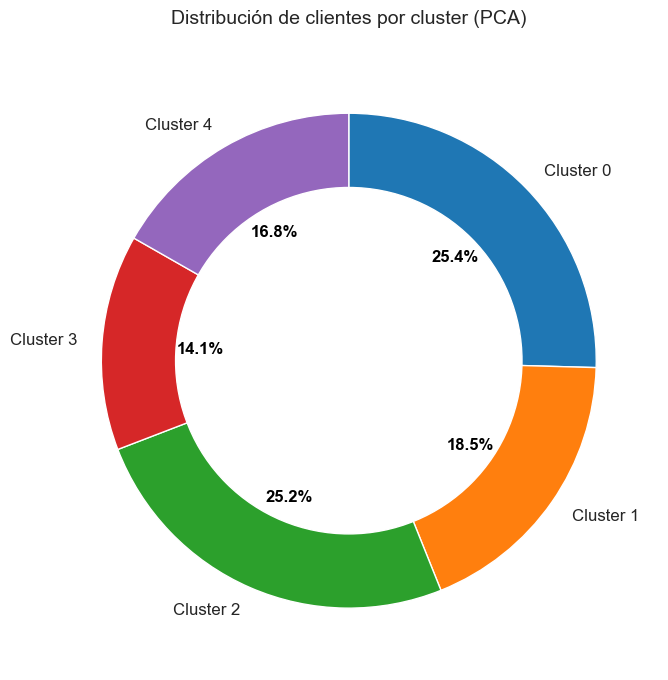

In [247]:
cluster_counts = df['Cluster_PCA'].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]
colors = plt.cm.tab10.colors[:len(cluster_counts)]
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(cluster_counts,
                                  labels=labels,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  counterclock=False,
                                  colors=colors,
                                  wedgeprops={'width': 0.4, 'edgecolor': 'white'})

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.setp(autotexts, size=12, weight="bold", color="black")
plt.title("Distribución de clientes por cluster (PCA)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [248]:
v_continuas = []
v_categoricas = []
for i in df.drop(columns=['Cluster_PCA']).columns:
    if df[i].nunique() > 55 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: Edad, Family_Size, Ingresos_anuales_brutos, Digital_encuesta, Gasto_medio_mensual_cuota, Dias_cliente, Campaña__0, Campaña__1, Campaña__3, Campaña__4, Campaña__5
Variables categóricas: Genero, Casado, Graduado, Experiencia_laboral, Gastoscore, Generacion, Abandono, Profesion, Zona


### **Caracterización por variables continuas.**
En esta sección analizamos cómo varían las variables numéricas entre los distintos clusters. Observamos aspectos como:
- La edad, los ingresos o el tamaño del hogar.
- Cuánto gastan al mes, cuánto tiempo llevan como clientes o su nivel de digitalización.
- Cuánto han interactuado con distintas campañas comerciales.

Gracias a los gráficos, podemos detectar en qué grupos hay personas más jóvenes, con más ingresos o más fidelizadas, lo que nos ayudará a entender mejor cada perfil y tomar decisiones adaptadas.

In [249]:
df[v_continuas].head(3)

,Edad,Family_Size,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Dias_cliente,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5
ID,,,,,,,,,,,
CLI10,67,3,93442,1385,80,195,1,0,0,0,0
CLI100,64,2,99774,1052,50,360,0,0,0,0,1
CLI1000,65,3,36756,1717,30,407,0,0,1,0,0


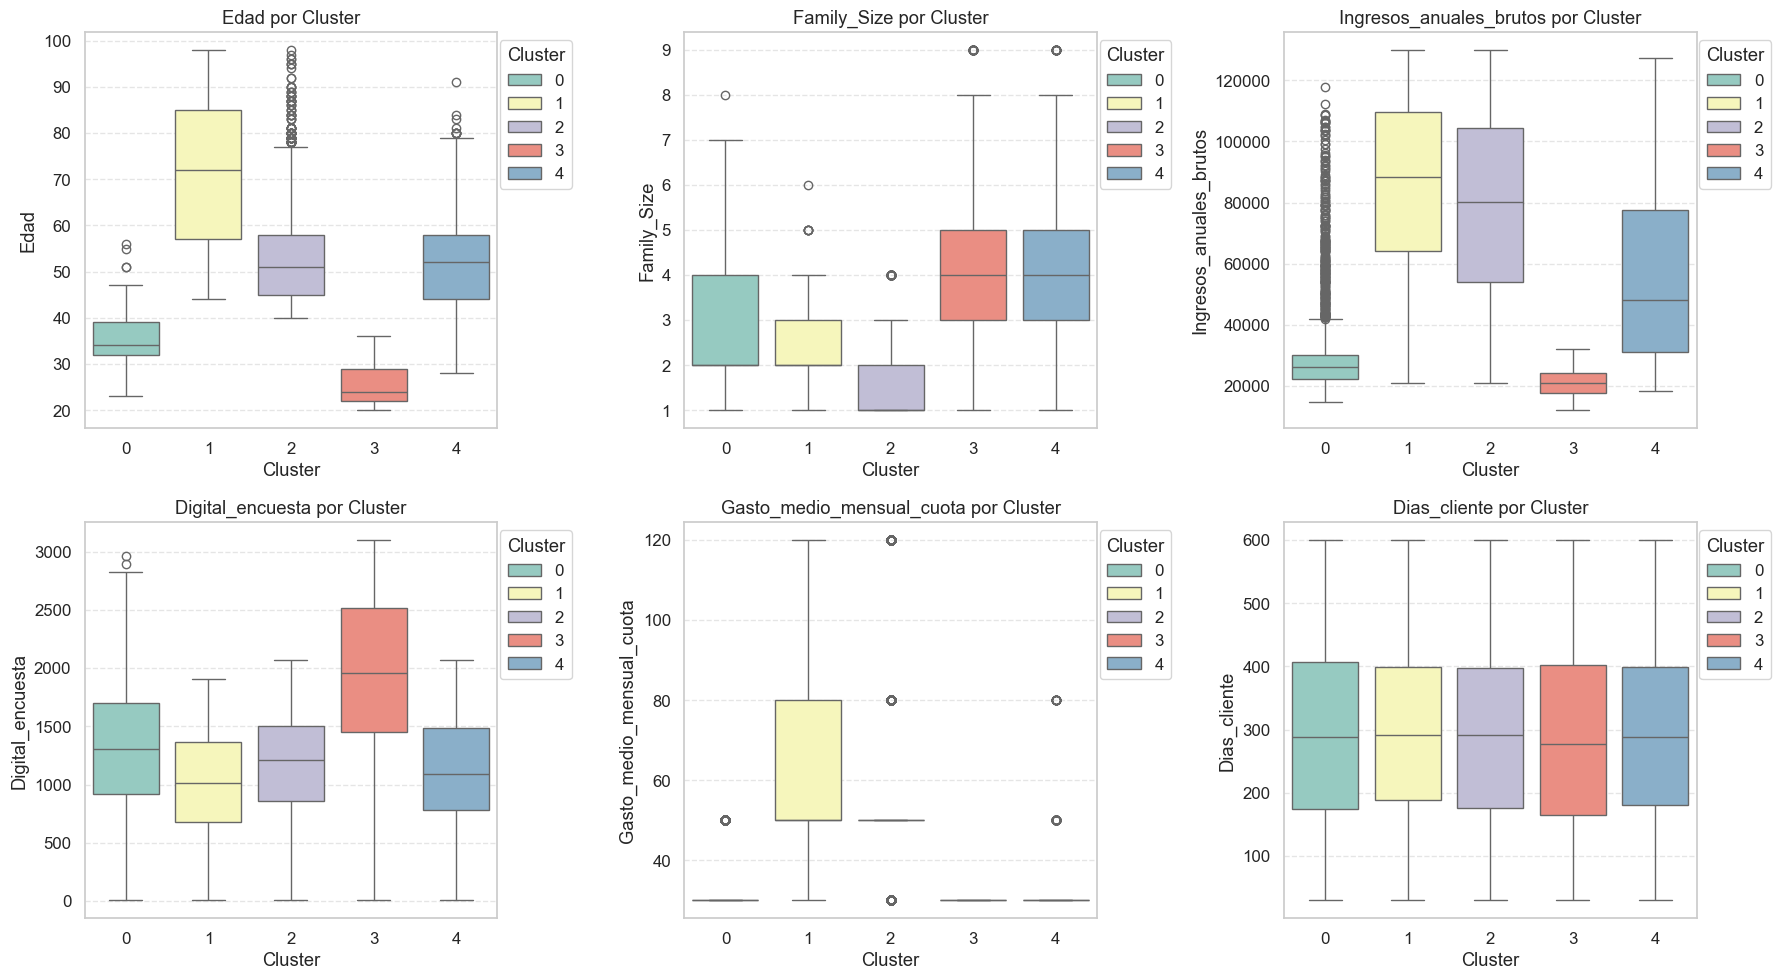

In [250]:
# Gráfica de boxplot para variables continuas por cluster.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, var in enumerate([var for var in v_continuas if var not in [f"Campaña__{i}" for i in range(7)]]):
    sns.boxplot(data=df, x='Cluster_PCA', y=var, ax=axs[i], palette="Set3", hue='Cluster_PCA')
    axs[i].set_title(f'{var} por Cluster')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(var)
    axs[i].legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Análisis de Variables Continuas por Cluster** La segmentación realizada a través de PCA ha permitido identificar **5 perfiles de clientes** diferenciados, los cuales pueden analizarse en mayor profundidad a partir de sus **características numéricas clave**. A continuación, se argumentan las particularidades observadas en cada cluster, con base en las variables continuas:

**Cluster 0 – Jóvenes con bajo poder adquisitivo, alta proyección digital.**
- **Edad**: Es el grupo más joven junto con el cluster 3.
- **Ingresos brutos**: Presentan los ingresos más bajos.
- **Gasto mensual en cuota**: También reducido.
- **Digitalización**: Alto uso de canales digitales.
- **Días como cliente**: Tienen una antigüedad intermedia.

*Este grupo muestra bajo poder adquisitivo pero un fuerte componente digital. Se confirma su potencial como segmento para estrategias de captación digital, especialmente si se orientan hacia crecimiento y fidelización temprana.*

**Cluster 1 – Adultos consolidados, alto ingreso, bajo nivel digital.**
- **Edad**: El grupo más adulto de todos.
- **Ingresos brutos**: De los más altos, con gran dispersión.
- **Gasto mensual**: También es el más elevado.
- **Digitalización**: Niveles bajos.
- **Tamaño del hogar**: Más pequeño, como se esperaría de adultos independientes.

*Se reafirma como perfil ideal para estrategias de productos financieros premium y servicios de largo plazo. No son digitales, pero tienen alto valor individual.*

**Cluster 2 – Clientes de alto poder adquisitivo y comportamiento selectivo.**
- **Edad**: Promedio medio-alto.
- **Ingresos**: Muy altos, aunque algo más estables que el cluster 1.
- **Gasto mensual**: Uniformemente alto.
- **Digitalización**: Baja, pero no tan crítica como en otros grupos.
- **Antigüedad**: Ligeramente superior a otros.

*Confirma su perfil como cliente de valor, poco afectado por influencias digitales. Perfecto para experiencias premium, personalizadas y de valor percibido alto.*

**Cluster 3 – Jóvenes digitales con bajo ingreso y grandes familias.**
- **Edad**: Grupo más joven del conjunto.
- **Digitalización**: El más alto de todos.
- **Ingresos y gasto mensual**: Los más bajos.
- **Tamaño familiar**: Más alto que la media.

*Se consolida como grupo muy digital, joven y familiar. Son ideales para campañas dinámicas, promociones online y estrategias de retención a través de tecnología y contenido.*

**Cluster 4 – Madurez media, familias grandes y bajo gasto.**
- **Edad**: Intermedia-alta.
- **Ingresos**: Moderados.
- **Gasto mensual**: Bajo, a pesar de ingresos decentes.
- **Familias grandes** y **uso digital bajo**.

*Perfil conservador y práctico. Pueden responder a beneficios funcionales, propuestas tradicionales, packs familiares o soluciones de valor económico alto.*

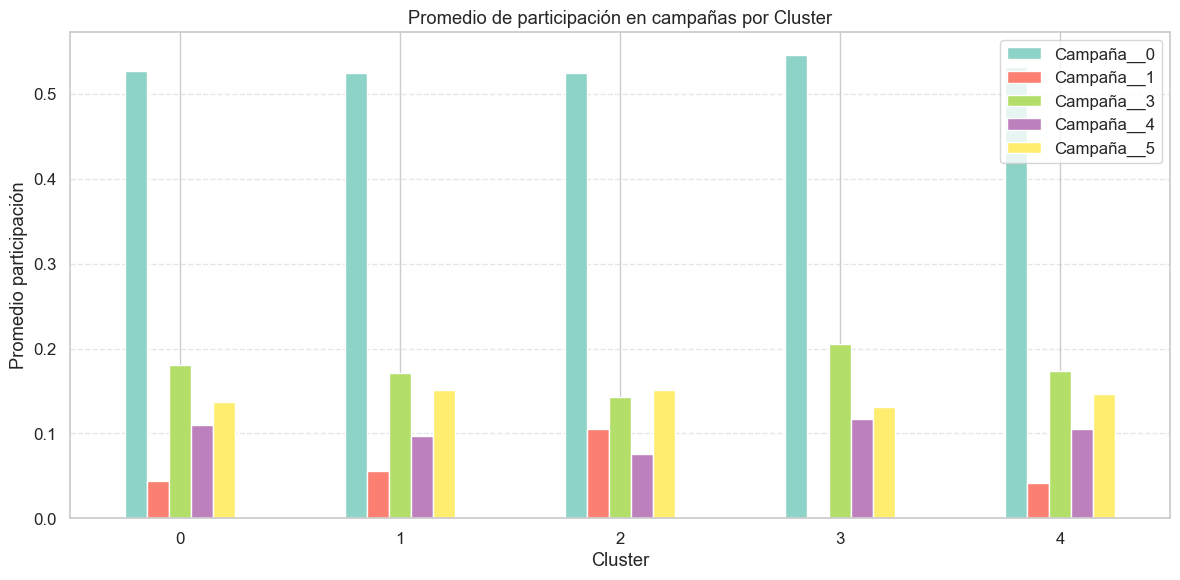

In [251]:
# Gráfica de barras para las variables de campaña.
campaign_means = df.groupby('Cluster_PCA')[[var for var in v_continuas if var in [f"Campaña__{i}" for i in range(7)]]].mean()

campaign_means.plot(kind='bar', figsize=(12, 6), colormap='Set3')
plt.title('Promedio de participación en campañas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Promedio participación')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Análisis del Comportamiento en Campañas por Cluster.**

| Cluster | Comportamiento frente a campañas |
|---------|----------------------------------|
| **Cluster 0** | Participación moderada en campaña 0 y **más baja en el resto**. Responden algo mejor a campañas 3 y 5, pero en general su comportamiento muestra **baja reactividad**. |
| **Cluster 1** | Muy similar al Cluster 0: **respuesta más alta a la campaña 0** y más floja en el resto. Se nota una **ligera mejora en campaña 5**, lo que puede indicar una pequeña sensibilidad a campañas recientes. |
| **Cluster 2** | Aunque campaña 0 sigue siendo la más común, destaca con **una mayor participación en campaña 1**, superior al resto. Esto sugiere que **este grupo podría haber sido más receptivo a esa campaña específica**, quizás por su perfil económico. |
| **Cluster 3** | El grupo **menos expuesto a campaña 1**, pero el **más alto en campaña 3**. Esto puede indicar que **tienen preferencias diferentes o que responden mejor a contenidos específicos más recientes o digitales**. |
| **Cluster 4** | Patrón parecido a los clusters 0 y 1. Alta participación en campaña 0 y una **respuesta homogénea en el resto**. Ligeramente mejores en campañas 3 y 5, pero sin destacar demasiado. |

**Conclusión.**
- La **campaña 0** fue claramente la más masiva o generalista, ya que todos los clusters tienen una participación similar.
- El **cluster 2 destaca en campaña 1**, lo que puede revelar sensibilidad a estrategias más selectivas o exclusivas.
- El **cluster 3 responde mucho mejor a campaña 3**, probablemente por ser el grupo **más joven y digital**.
- El **resto de campañas (4 y 5)** mantienen un comportamiento regular, sin grandes diferencias, aunque **ligeramente mejores en los clusters 1 y 4**.

### **Caracterización por variables categóricas.**
En esta sección se analizan las variables categóricas del dataset con el objetivo de entender cómo se distribuyen los perfiles sociodemográficos y conductuales dentro de cada cluster. Este análisis permite identificar patrones de comportamiento y diferencias estructurales entre los grupos segmentados.

In [252]:
df[v_categoricas].head(3)

,Genero,Casado,Graduado,Experiencia_laboral,Gastoscore,Generacion,Abandono,Profesion,Zona
ID,,,,,,,,,
CLI10,Femenino,Sí,Sí,+20annos,Bajo,Generacion X,Sí,Técnico,Noroeste
CLI100,Masculino,Sí,Sí,+20annos,Medio,Generacion X,Sí,Técnico,Levante
CLI1000,Masculino,Sí,Sí,+20annos,Medio,Generacion X,No,Servicios,Centro


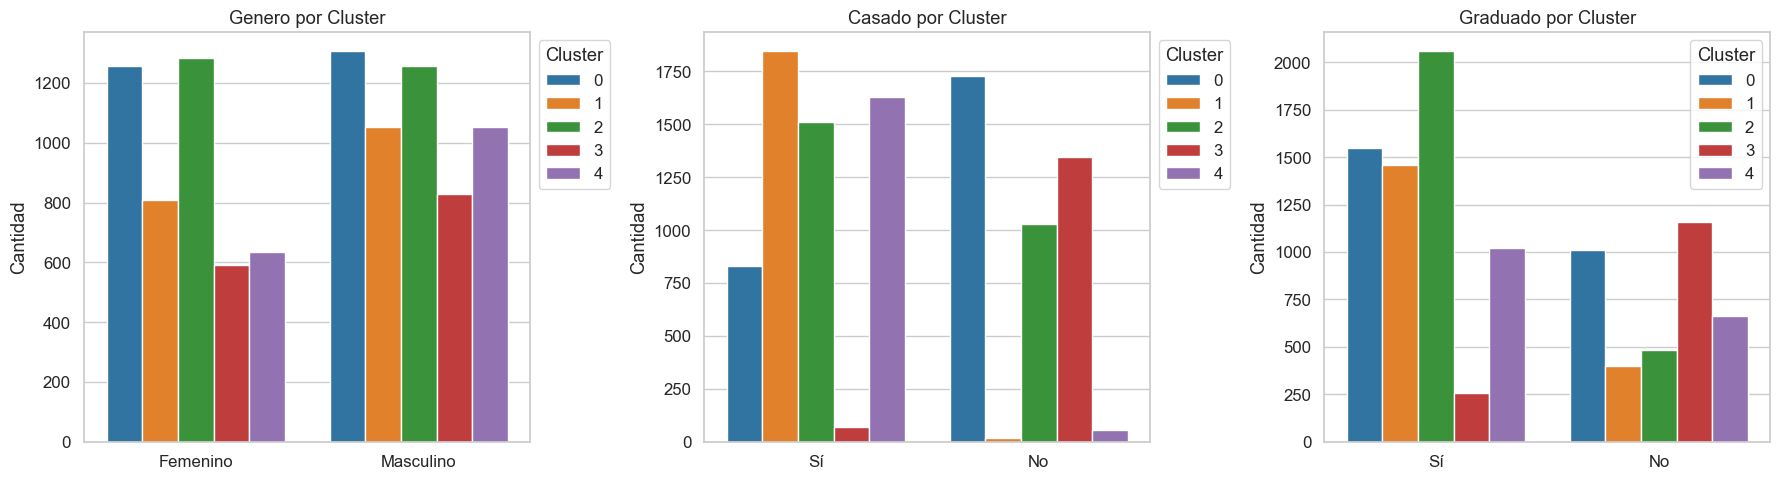

In [ ]:
# Parte 1: Género, Casado y Graduado.
categorical_vars_1 = ['Genero', 'Casado', 'Graduado']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var in zip(axes, categorical_vars_1):
    sns.countplot(data=df, x=var, hue='Cluster_PCA', palette='tab10', ax=ax)
    ax.set_title(f'{var} por Cluster')
    ax.set_xlabel('')
    ax.set_ylabel('Cantidad')
    ax.legend(title='Cluster', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Análisis de Variables Categóricas (I): Género, Casado y Graduado.**

| Variable   | Hallazgos por cluster |
|------------|------------------------|
| **Género** | La distribución por género es bastante equilibrada en todos los clusters, aunque el cluster 3 muestra una ligera mayoría masculina, mientras que el 2 se inclina por el femenino. |
| **Casado** | El cluster 1 agrupa principalmente personas casadas, mientras que el 0 y 3 destacan por una mayor proporción de personas solteras. |
| **Graduado** | El cluster 2 es el más académico (mayor proporción de graduados), mientras que el cluster 3 concentra el mayor porcentaje sin estudios universitarios. |

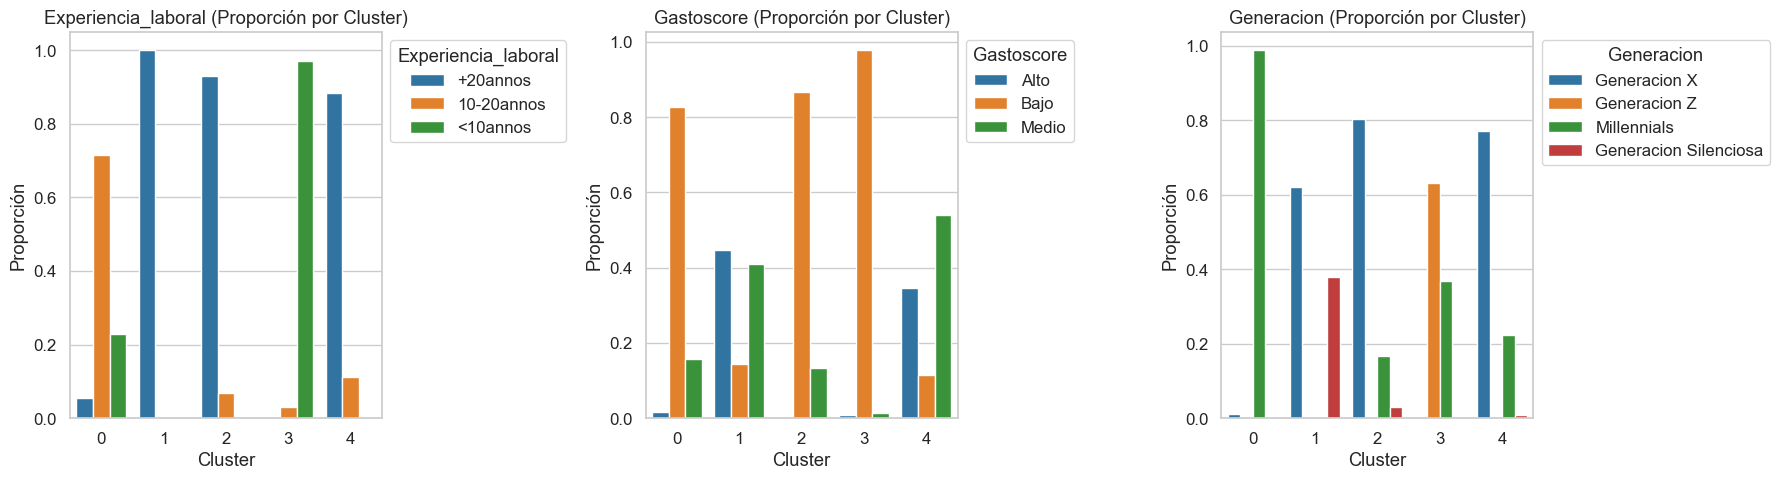

In [256]:
# Parte 2: Experiencia_laboral, Gastoscore, Generacion.
categorical_vars_2 = ['Experiencia_laboral', 'Gastoscore', 'Generacion']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var in zip(axes, categorical_vars_2):
    prop_df = df.groupby(['Cluster_PCA', var]).size().reset_index(name='count')
    total = prop_df.groupby('Cluster_PCA')['count'].transform('sum')
    prop_df['proporcion'] = prop_df['count'] / total

    sns.barplot(
        data=prop_df,
        x='Cluster_PCA', y='proporcion', hue=var,
        ax=ax, palette='tab10'
    )
    ax.set_title(f'{var} (Proporción por Cluster)')
    ax.set_ylabel('Proporción')
    ax.set_xlabel('Cluster')
    ax.legend(title=var, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Análisis de Variables Categóricas (II): Experiencia, Gasto y Generación.**

| Variable                 | Hallazgos por cluster |
|--------------------------|------------------------|
| **Experiencia laboral** | El cluster 1 se compone mayoritariamente de perfiles con más de 20 años de experiencia, lo que refuerza su perfil consolidado. El cluster 3, en cambio, concentra a los menos experimentados (<10 años), mientras que el cluster 0 agrupa principalmente experiencia media. |
| **Gasto Score**          | El cluster 0 tiene una clara mayoría con score **bajo**, reflejando menor capacidad o hábitos de consumo. Clusters 1 y 2 destacan por presencia de **score medio y alto**, lo que valida su perfil económico más robusto. |
| **Generación**          | El cluster 0 está compuesto casi exclusivamente por **Millennials** (98%), mientras que el cluster 3 se distingue por una mayoría de **Generación Z** (63%). El cluster 2 es mayoritariamente **Generación X** (80%), y el cluster 1 combina **Generación X** y **Silenciosa**, formando el grupo más adulto y tradicional. |

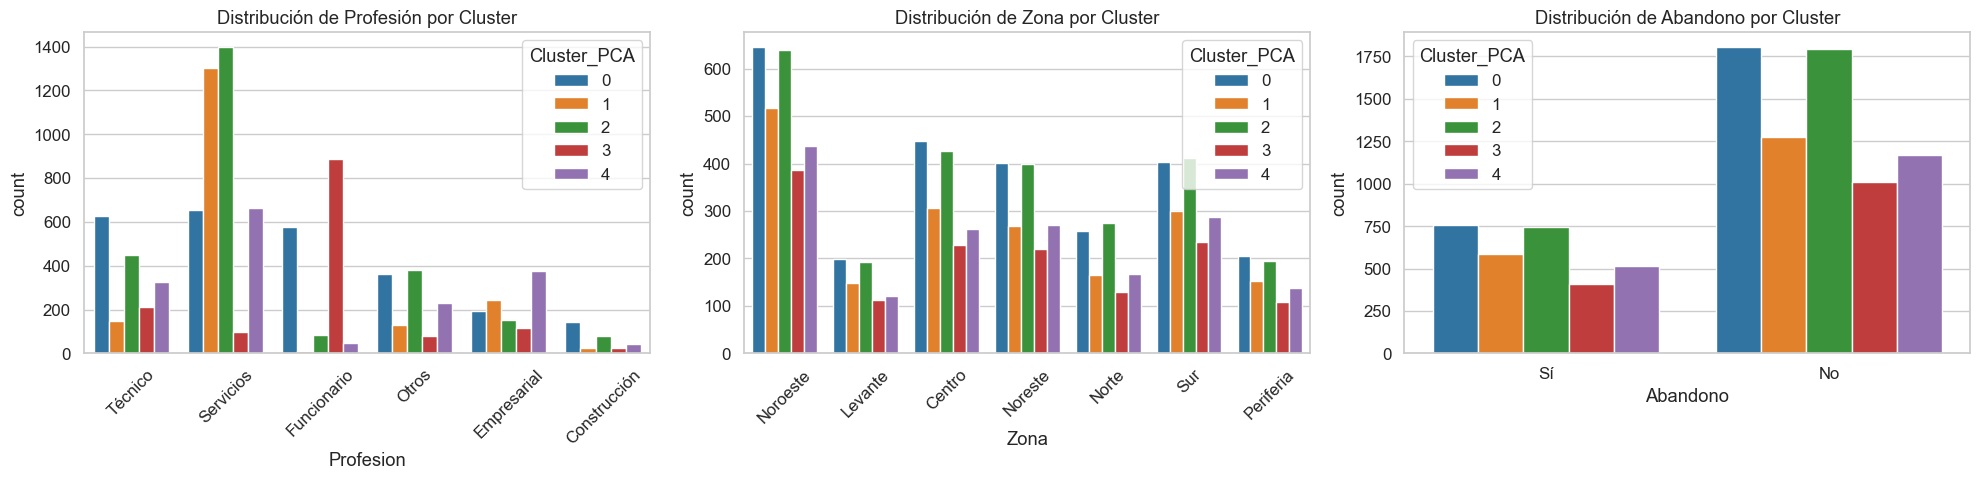

In [258]:
# Crear gráficos para Profesión, Zona y Abandono
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Profesión.
sns.countplot(data=df, x='Profesion', hue='Cluster_PCA', palette='tab10', ax=axes[0])
axes[0].set_title('Distribución de Profesión por Cluster')
axes[0].tick_params(axis='x', rotation=45)

# Zona.
sns.countplot(data=df, x='Zona', hue='Cluster_PCA', palette='tab10', ax=axes[1])
axes[1].set_title('Distribución de Zona por Cluster')
axes[1].tick_params(axis='x', rotation=45)

# Abandono.
sns.countplot(data=df, x='Abandono', hue='Cluster_PCA', palette='tab10', ax=axes[2])
axes[2].set_title('Distribución de Abandono por Cluster')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [261]:
df['Abandono'].groupby(df['Cluster_PCA']).value_counts(normalize=True).unstack().fillna(0).round(2)

Abandono,No,Sí
Cluster_PCA,,
0,0.70,0.30
1,0.68,0.32
2,0.71,0.29
3,0.71,0.29
4,0.69,0.31


**Análisis de Variables Categóricas (II): Profesión, Zona geográfica y Abandono.**

| Variable     | Hallazgos por cluster |
|--------------|------------------------|
| **Profesión** | **Cluster 0** es diverso, con equilibrio entre técnicos, servicios y funcionarios. **Cluster 1** se concentra fuertemente en el sector **Servicios**. **Cluster 2** combina servicios con técnicos y otros perfiles. **Cluster 3** está dominado por **funcionarios**, siendo el más homogéneo. **Cluster 4** es el más equilibrado, con mezcla de empresariales, técnicos y servicios. |
| **Zona geográfica** | Todos los clusters presentan una distribución bastante similar. **El Noroeste** es la zona más frecuente en todos los grupos, seguido por **Centro** y **Noreste**. Las zonas de **Periferia** y **Levante** tienen menor presencia relativa. No hay un patrón geográfico diferenciador fuerte, pero el **Cluster 1** y el **Cluster 3** tienen una ligera mayor representación en el **Noroeste**.  |
| **Abandono** | Todos los clusters presentan tasas similares de abandono. El **Cluster 2** y el **Cluster 3** tienen la proporción **más baja de abandono**, lo que sugiere mayor estabilidad o satisfacción. El **Cluster 1** muestra la tasa **ligeramente más alta**, lo que podría indicar una sensibilidad mayor ante fallos en la experiencia o expectativas más altas. |

### **Naming Estratégico de los Clusters.**
Después de analizar en profundidad las variables continuas y categóricas, podemos sintetizar el comportamiento de cada grupo en un perfil tipo. Este proceso de naming estratégico nos permite asignar a cada cluster una etiqueta descriptiva y fácil de comunicar, que resume sus características clave.

El objetivo es facilitar la comprensión y la aplicación práctica de los resultados por parte del equipo de negocio, marketing o atención al cliente. Cada nombre resume la esencia sociodemográfica, económica y conductual del segmento.

A continuación, se presenta una tabla resumen con el perfil de cada cluster y su denominación propuesta.


| Cluster | Nombre conceptual                  | Nombre marketing     | Perfil resumido |
|---------|------------------------------------|-----------------------|------------------|
| **0**   | *Jóvenes digitales en crecimiento* | *Exploradores*     | Millennials, bajo ingreso y gasto, alto uso digital, profesiones técnicas y públicas. Buen target para captación y activación online. |
| **1**   | *Adultos consolidados del sector servicios* | *Tradicionales Plus* | Generación X/Silenciosa, ingresos altos, casados, poco digitales, concentrados en Servicios. Fidelización, productos premium y trato personalizado. |
| **2**   | *Clientes premium estables*       | *Alta Rentabilidad* | Estabilidad profesional y económica, empresariales y técnicos, muy baja tasa de abandono. Ideales para estrategias de valor y retención silenciosa. |
| **3**   | *Familias jóvenes digitales*      | *Familias Z*       | Generación Z, muy digitales, funcionarios, ingresos bajos, hogares grandes. Clave para promociones online, fidelización y gamificación. |
| **4**   | *Clase media práctica y versátil* | *Multiuso Familiar* | Perfil mixto, Generación X, profesiones variadas, ingreso y gasto medios, zonas intermedias. Versátiles para campañas masivas o familiares. |

In [263]:
df.to_csv('../data/processed/IA_Client_Segment_sample_v3.csv', index=True) # Guardar el dataset final.